In [43]:
import torch
from torch.utils.data import DataLoader
from efficientnet.model import EfficientNet
# from model import *

from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets, models
from loss_function import *
from dataload_classification import *
from utils_classification import *
from metrics import *

import glob
import shutil

import pandas as pd
import numpy as np

from PIL import Image
import sklearn
import scipy

from sklearn.model_selection import KFold
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import warnings
warnings.filterwarnings('always')

print('Number of available devices ', torch.cuda.device_count())
# GPU 할당 변경하기
gpu_ids = 0  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{gpu_ids}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print('Current devices ', torch.cuda.current_device())

# I expect to see RuntimeWarnings in this block

## 트레이닝 파라메터 설정하기
lr = 1e-4
batch_size = 32
num_epoch = 300
pros = 'ex4'
print(os.getcwd())
# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')

data_dir = './data/20220320_classification'
ckpt_dir = './result/20220320_classification_wc_eff_b2/checkpoint'

log_dir = './result/20220320_classification_wc_eff_b2/log'
result_dir = './result/20220320_classification_wc_eff_b2/result'

mode = 'train'
train_continue = 'off'

# device = 'cpu'
print("device: ", device)
print("learning rate: %.4e" % lr)
print("batch size: %d" % batch_size)
print("number of epoch: %d" % num_epoch)
print("data dir: %s" % data_dir)
print("ckpt dir: %s" % ckpt_dir)
print("log dir: %s" % log_dir)
print("result dir: %s" % result_dir)
print("mode: %s" % mode)
print("GPU ID : %s" % gpu_ids)
print("K-fold cross validation : %s" % str(kf_type))

## 디렉토리 생성하기

if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

## 그밖에 부수적인 functions 설정하기

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

## Tensorboard 를 사용하기 위한 SummaryWriter 설정

writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# TEST MODE
# TEST MODE

def save_best_npy(FOLD, testPath,pros):

    if pros == 'ex1':
        classes = ( '0', '1') 
        classes_name = [ '0','1'] 
        ex = 1
        num_classes = 2
    elif pros == 'ex2':
        classes = ( '0', '2') 
        classes_name = [ '0','2'] 
        ex = 2
        num_classes = 2
    elif pros == 'ex3':
        classes = ( '1', '2') 
        classes_name = [ '1','2'] 
        ex = 3
        num_classes = 2
    elif pros == 'ex4':
        classes = ( '0', '1','2') 
        classes_name = [ '0','1','2'] 
        ex = 4
        num_classes = 3
        
    print(classes)
    print(classes_name)
    print(pros)
    print(num_classes)

    transform = transforms.Compose([Normalization(), ToTensor()])
    dataset_test = Dataset(data_dir=testPath, classes=classes, ex = ex,transform=transform, target_transform=transform,s= 96) ########################################################################################
        
    # 그밖에 부수적인 variables 설정하기
    num_data_test = len(dataset_test)

    ## 네트워크 생성하기
    #resnet = models.resnet101(pretrained=True)
    num_classes = num_classes ########################################################################################
    model  = EfficientNet.from_pretrained('efficientnet-b2',in_channels = 1,num_classes= num_classes)
    net = model.to(device)

    ## Optimizer 설정하기
    optim = torch.optim.SGD(net.parameters(), lr=lr, momentum = 0.9, weight_decay = 0.0001)

    loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

    best_model_name = [j for j in os.listdir(ckpt_dir) if 'best_fold' + str(FOLD) in j][0]

    dict_model = torch.load('%s/%s' % (ckpt_dir, best_model_name))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    #######################################################
    with torch.no_grad():
        net.eval()

        count_total = 0

        loss_arr = []
        valid_loss = []
        results = []

        y_pred_list = []
        y_label_list = []

        ID_list =[]
        class_0_proba_list = []
        class_1_proba_list = []
        class_2_proba_list = []

        for batch, data in enumerate(loader_test, 1):
            count = 0

            label = data['label'].to(device)
            input = data['input'].to(device)
            
            input_id = data['Input_ID']
            print(input_id)
            output = net(input)
            
            y_pred_softmax = torch.softmax(output, dim=1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
            
            print(y_pred_softmax.to('cpu').detach().numpy().shape)
            
            if pros == 'ex1':
                class_0_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,0]) 
                class_1_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,1])

            elif pros == 'ex2':
                class_0_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,0]) 
                class_2_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,1])
            
            elif pros == 'ex3':
                class_1_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,0]) 
                class_2_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,1])
                
            elif pros == 'ex4':
                class_0_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,0]) 
                class_1_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,1])
                class_2_proba_list +=list(y_pred_softmax.to('cpu').detach().numpy()[:,2])
            
            y_label_list += list(label.to('cpu').detach().numpy())
            y_pred_list += list(y_pred_tags.to('cpu').detach().numpy())
            ID_list +=list(input_id)

        if pros == 'ex1':
            result = pd.DataFrame(data={'ID': ID_list, 'class_0_proba':class_0_proba_list,'class_1_proba':class_1_proba_list, 'y_pred': y_pred_list,'y_label':y_label_list})

        elif pros == 'ex2':
            result = pd.DataFrame(data={'ID': ID_list, 'class_0_proba':class_0_proba_list,'class_2_proba':class_2_proba_list, 'y_pred': y_pred_list,'y_label':y_label_list})

        elif pros == 'ex3':
            result = pd.DataFrame(data={'ID': ID_list, 'class_1_proba':class_1_proba_list,'class_2_proba':class_2_proba_list, 'y_pred': y_pred_list,'y_label':y_label_list})

        elif pros == 'ex4':
            result = pd.DataFrame(data={'ID': ID_list, 'class_0_proba':class_0_proba_list, 'class_1_proba':class_1_proba_list,'class_2_proba':class_2_proba_list, 'y_pred': y_pred_list,'y_label':y_label_list})

    return result

# TEST MODE
# TEST MODE

def get_cv(fold, data_dir):
    cv_num = [0, 1, 2, 3, 4]
    train = []

    for i in range(0, 5):
        num = fold + i
        if num >= 5:
            num = num - 5
        if i <= 2:
            train_i = os.path.join(data_dir, 'CV' + str(cv_num[num] + 1))
            train += [train_i]
        if i == 3:
            val = [os.path.join(data_dir, 'CV' + str(cv_num[num] + 1))]
        if i == 4:
            test = [os.path.join(data_dir, 'CV' + str(cv_num[num] + 1))]

    return train, val, test

train, val, test = get_cv(0, data_dir)
results1 =save_best_npy(1, test,pros)
results1.to_csv(os.path.join(result_dir,'test', 'results1.csv'))

train, val, test = get_cv(1, data_dir)
results2 =save_best_npy(2, test,pros)
results2.to_csv(os.path.join(result_dir,'test', 'results2.csv'))
train, val, test = get_cv(2, data_dir)
results3 =save_best_npy(3, test,pros)
results3.to_csv(os.path.join(result_dir,'test', 'results3.csv'))
train, val, test =get_cv(3, data_dir)
results4 = save_best_npy(4, test,pros)
results4.to_csv(os.path.join(result_dir,'test', 'results4.csv'))
train, val, test =get_cv(4, data_dir)
results5 = save_best_npy(5, test,pros)
results5.to_csv(os.path.join(result_dir,'test', 'results5.csv'))
results_all = pd.concat([results1 ,results2,results3,results4,results5], axis = 0)
results_all.to_csv(os.path.join(result_dir,'test', 'results_all.csv'))

Number of available devices  4
Current devices  3
/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver
device:  cuda:3
learning rate: 1.0000e-03
batch size: 32
number of epoch: 300
data dir: ./data/20220320_classification_3
ckpt dir: ./result/20220320_classification_wc_eff_b2_step2/checkpoint
log dir: ./result/20220320_classification_wc_eff_b2_step2/log
result dir: ./result/20220320_classification_wc_eff_b2_step2/result
mode: train
GPU ID : 3
K-fold cross validation : True
('0', '2')
['0', '2']
ex2
2
Loaded pretrained weights for efficientnet-b2
['20020812_11812293_num_1_class_0_img.tiff', '20020812_11812293_num_2_class_0_img.tiff', '20030220_3848703_num_1_class_0_img1.tiff', '20030220_3848703_num_2_class_0_img.tiff', '20030705_19625293_num_1_class_0_img.tiff', '20030819_19194363_num_1_class_0_img.tiff', '20030819_19194363_num_2_class_0_img.tiff', '20030819_19194363_num_3_class_0_img.tiff', '20030828_7112123_num_1_class_0_img1.tiff', '20040624_20339283_num_1_class_0_img.tiff', '20040624_2033

['20130110_28963783_num_2_class_0_img.tiff', '20130110_28963783_num_3_class_0_img.tiff', '20130110_28963783_num_4_class_0_img.tiff', '20130110_28963783_num_5_class_0_img1.tiff', '20130110_28963783_num_6_class_0_img.tiff', '20130129_11643323_num_1_class_0_img.tiff', '20130129_11643323_num_2_class_0_img1.tiff', '20130131_18201563_num_1_class_0_img.tiff', '20130131_18201563_num_2_class_0_img.tiff', '20130131_18201563_num_3_class_0_img.tiff', '20130131_18201563_num_4_class_0_img.tiff', '20130208_25376853_num_1_class_0_img.tiff', '20130225_26072743_num_1_class_0_img.tiff', '20130225_26072743_num_2_class_0_img.tiff', '20130305_29922783_num_1_class_0_img.tiff', '20130524_29792483_num_2_class_0_img1.tiff', '20130524_29792483_num_3_class_0_img1.tiff', '20130528_24018643_num_1_class_0_img1.tiff', '20130702_29728883_num_1_class_0_img.tiff', '20130702_29728883_num_2_class_0_img.tiff', '20130718_14553413_num_1_class_0_img.tiff', '20130718_14553413_num_2_class_0_img.tiff', '20130718_27098503_num_1_c

['20150930_17065513_num_2_class_2_img.tiff', '20150930_17065513_num_3_class_2_img.tiff', '20150930_17065513_num_4_class_2_img.tiff', '20151110_25480123_num_1_class_0_img1.tiff', '20151110_25480123_num_2_class_0_img.tiff', '20151119_4624493_num_1_class_0_img.tiff', '20151119_4624493_num_2_class_0_img.tiff', '20151119_4624493_num_3_class_0_img.tiff', '20151119_4624493_num_4_class_0_img.tiff', '20151119_4624493_num_5_class_0_img.tiff', '20160205_747733_num_1_class_0_img.tiff', '20160205_747733_num_2_class_0_img.tiff', '20160318_33741663_num_1_class_0_img.tiff', '20160318_33741663_num_2_class_0_img.tiff', '20160318_33741663_num_3_class_0_img.tiff', '20160318_33741663_num_4_class_0_img.tiff', '20160407_287123_num_1_class_0_img.tiff', '20160407_33780963_num_1_class_0_img.tiff', '20160420_13835953_num_1_class_0_img.tiff', '20160804_22150023_num_1_class_0_img.tiff', '20160804_22150023_num_2_class_0_img.tiff', '20160804_22150023_num_3_class_0_img.tiff', '20160901_21963593_num_1_class_0_img.tiff

['20190503_5906563_num_4_class_0_img.tiff', '20190507_18034443_num_1_class_0_img1.tiff', '20190507_18034443_num_2_class_0_img.tiff', '20190507_18034443_num_3_class_0_img.tiff', '20190516_28372773_num_1_class_2_img.tiff', '20190516_28372773_num_2_class_2_img.tiff', '20190516_28372773_num_3_class_2_img.tiff', '20190524_18199123_num_1_class_0_img.tiff', '20190527_17070313_num_1_class_2_img.tiff', '20190531_20120313_num_1_class_2_img.tiff', '20190531_20120313_num_2_class_2_img.tiff', '20190531_20120313_num_3_class_2_img.tiff', '20190612_40539830_num_1_class_0_img.tiff', '20190612_40539830_num_2_class_0_img.tiff', '20190612_40539830_num_3_class_0_img.tiff', '20190614_30530073_num_1_class_2_img1.tiff', '20190614_30530073_num_1_class_2_img2.tiff', '20190614_30530073_num_2_class_2_img1.tiff', '20190620_27485803_num_3_class_0_img.tiff', '20190620_27485803_num_4_class_0_img1.tiff', '20190624_40627270_num_1_class_0_img.tiff', '20190624_40627270_num_2_class_0_img.tiff', '20190625_18305353_num_1_cl

['20210120_41547377_num_7_class_0_img.tiff', '20210126_20985253_num_1_class_0_img.tiff', '20210128_22463133_num_1_class_2_img.tiff', '20210129_10270813_num_1_class_2_img.tiff', '20210129_10270813_num_2_class_2_img.tiff', '20210325_14197603_num_1_class_2_img.tiff', '20210408_26471483_num_1_class_2_img.tiff', '20210421_8222173_num_1_class_2_img.tiff', '20210421_8222173_num_2_class_2_img.tiff', '20210421_8222173_num_3_class_2_img1.tiff', '20210421_8222173_num_4_class_2_img.tiff', '20210421_8222173_num_5_class_2_img.tiff', '20210421_8222173_num_6_class_2_img.tiff', '20210421_8222173_num_7_class_2_img.tiff', '20210421_8222173_num_8_class_2_img.tiff', '20210422_12519943_num_1_class_0_img1.tiff', '20210506_41842205_num_1_class_0_img.tiff', '20210511_24625553_num_1_class_0_img.tiff', '20210511_24625553_num_2_class_0_img.tiff', '20210511_24625553_num_3_class_0_img.tiff', '20210514_41850150_num_1_class_0_img.tiff', '20210514_41850150_num_4_class_0_img1.tiff', '20210521_18493183_num_1_class_2_img

['20020820_18764113_num_1_class_0_img.tiff', '20020820_18764113_num_2_class_0_img.tiff', '20020827_18783333_num_1_class_0_img.tiff', '20030908_10728243_num_1_class_0_img.tiff', '20030908_10728243_num_2_class_0_img.tiff', '20031020_18522243_num_1_class_0_img.tiff', '20040617_12951193_num_2_class_0_img.tiff', '20040723_20266243_num_1_class_0_img.tiff', '20040723_20266243_num_2_class_0_img.tiff', '20041129_20947953_num_1_class_0_img.tiff', '20041129_20947953_num_2_class_0_img.tiff', '20050119_3006693_num_1_class_0_img.tiff', '20050511_14370943_num_1_class_0_img.tiff', '20050511_14370943_num_2_class_0_img.tiff', '20051021_21715843_num_1_class_0_img.tiff', '20051021_21715843_num_2_class_0_img.tiff', '20060328_10465253_num_1_class_0_img.tiff', '20060504_19150063_num_1_class_0_img.tiff', '20060721_14645873_num_2_class_0_img.tiff', '20060721_14645873_num_3_class_0_img.tiff', '20060807_22513863_num_1_class_0_img.tiff', '20060807_22513863_num_2_class_0_img.tiff', '20060807_22513863_num_3_class_0

['20130703_30424103_num_2_class_0_img.tiff', '20130704_6599113_num_1_class_0_img1.tiff', '20130704_6599113_num_2_class_0_img1.tiff', '20130704_6599113_num_3_class_0_img.tiff', '20130704_6599113_num_4_class_0_img1.tiff', '20130704_6599113_num_5_class_0_img.tiff', '20130704_6599113_num_6_class_0_img.tiff', '20130715_18680823_num_1_class_0_img.tiff', '20130715_18680823_num_2_class_0_img.tiff', '20130715_18680823_num_3_class_0_img.tiff', '20130716_18302433_num_1_class_0_img.tiff', '20130716_18302433_num_2_class_0_img.tiff', '20130716_18302433_num_3_class_0_img.tiff', '20130716_18302433_num_4_class_0_img.tiff', '20130719_18224263_num_3_class_0_img.tiff', '20130719_30336053_num_1_class_0_img.tiff', '20130903_25389383_num_1_class_0_img.tiff', '20130903_25389383_num_2_class_0_img.tiff', '20130903_25389383_num_4_class_0_img.tiff', '20130906_30615523_num_1_class_0_img.tiff', '20130906_30615523_num_2_class_0_img.tiff', '20130906_30615523_num_3_class_0_img.tiff', '20130912_30621133_num_1_class_0_i

['20160331_21310283_num_2_class_0_img.tiff', '20160426_18739793_num_1_class_0_img.tiff', '20160427_26255813_num_1_class_0_img.tiff', '20160427_26255813_num_2_class_0_img.tiff', '20160509_14482223_num_1_class_0_img.tiff', '20160509_14482223_num_2_class_0_img.tiff', '20160509_14482223_num_3_class_0_img.tiff', '20160511_31622763_num_2_class_0_img1.tiff', '20160511_31622763_num_3_class_0_img.tiff', '20160609_11041743_num_1_class_0_img.tiff', '20160729_5820003_num_1_class_0_img1.tiff', '20160920_34266723_num_1_class_0_img.tiff', '20160920_34266723_num_2_class_0_img.tiff', '20160926_34258793_num_1_class_0_img.tiff', '20160926_34258793_num_2_class_0_img.tiff', '20160926_34258793_num_3_class_0_img.tiff', '20160926_34258793_num_4_class_0_img.tiff', '20160926_34258793_num_5_class_0_img.tiff', '20160930_14346793_num_1_class_0_img.tiff', '20160930_14346793_num_2_class_0_img.tiff', '20160930_14346793_num_3_class_0_img.tiff', '20160930_14346793_num_4_class_0_img.tiff', '20160930_14346793_num_5_class

['20190820_12558143_num_1_class_2_img1.tiff', '20190827_10547243_num_1_class_2_img.tiff', '20190827_10547243_num_2_class_2_img.tiff', '20190827_5617273_num_1_class_0_img.tiff', '20190827_5617273_num_3_class_0_img.tiff', '20190829_17127723_num_2_class_2_img.tiff', '20190903_32030063_num_1_class_0_img1.tiff', '20190910_317792_num_1_class_2_img.tiff', '20191108_29732753_num_1_class_0_img.tiff', '20191112_32690023_num_1_class_0_img.tiff', '20191121_9130973_num_1_class_2_img.tiff', '20191121_9130973_num_2_class_2_img.tiff', '20191204_17154953_num_1_class_2_img.tiff', '20191205_40881865_num_2_class_2_img.tiff', '20191205_5817163_num_4_class_2_img.tiff', '20191206_28241073_num_1_class_2_img.tiff', '20191206_28241073_num_2_class_2_img.tiff', '20191217_27073233_num_1_class_0_img1.tiff', '20191217_27073233_num_2_class_0_img1.tiff', '20191217_27073233_num_3_class_0_img.tiff', '20191217_27073233_num_4_class_0_img.tiff', '20191231_5355223_num_1_class_0_img.tiff', '20191231_5355223_num_2_class_0_img

['20210408_30688973_num_1_class_2_img.tiff', '20210420_40713087_num_1_class_2_img1.tiff', '20210420_40713087_num_2_class_2_img1.tiff', '20210420_40713087_num_2_class_2_img2.tiff', '20210420_40713087_num_3_class_2_img.tiff', '20210421_26221063_num_10_class_0_img.tiff', '20210421_26221063_num_11_class_0_img.tiff', '20210421_26221063_num_12_class_0_img.tiff', '20210421_26221063_num_1_class_0_img.tiff', '20210421_26221063_num_2_class_0_img.tiff', '20210421_26221063_num_3_class_0_img.tiff', '20210421_26221063_num_4_class_0_img.tiff', '20210421_26221063_num_5_class_0_img.tiff', '20210421_26221063_num_6_class_0_img.tiff', '20210421_26221063_num_7_class_0_img.tiff', '20210421_26221063_num_8_class_0_img.tiff', '20210421_26221063_num_9_class_0_img.tiff', '20210423_29749023_num_1_class_0_img.tiff', '20210423_29749023_num_2_class_0_img.tiff', '20210429_41498709_num_1_class_0_img.tiff', '20210507_8530163_num_1_class_2_img1.tiff', '20210520_21464093_num_1_class_2_img.tiff', '20210520_21464093_num_2_

Loaded pretrained weights for efficientnet-b2
['20030324_19362433_num_2_class_0_img.tiff', '20030510_19379053_num_1_class_0_img.tiff', '20041012_20839363_num_1_class_0_img.tiff', '20041012_20839363_num_2_class_0_img.tiff', '20041213_321642_num_1_class_0_img.tiff', '20041213_321642_num_2_class_0_img.tiff', '20050323_13106753_num_1_class_0_img.tiff', '20050607_16427733_num_1_class_0_img.tiff', '20050607_16427733_num_2_class_0_img.tiff', '20050718_644683_num_3_class_0_img.tiff', '20050718_644683_num_6_class_0_img.tiff', '20050804_21544603_num_1_class_0_img.tiff', '20050804_21544603_num_2_class_0_img.tiff', '20051024_21686873_num_1_class_0_img1.tiff', '20051024_21686873_num_2_class_0_img.tiff', '20051024_21686873_num_3_class_0_img.tiff', '20051104_17154993_num_4_class_0_img.tiff', '20051206_16295463_num_1_class_0_img.tiff', '20051229_21667373_num_1_class_0_img.tiff', '20051229_21667373_num_2_class_0_img.tiff', '20060413_7205083_num_1_class_0_img.tiff', '20060413_7205083_num_2_class_0_img.t

['20121113_8779383_num_2_class_0_img.tiff', '20121113_8779383_num_3_class_0_img.tiff', '20130110_10577503_num_1_class_0_img.tiff', '20130110_10577503_num_2_class_0_img.tiff', '20130110_10577503_num_3_class_0_img.tiff', '20130110_10577503_num_4_class_0_img.tiff', '20130110_10577503_num_5_class_0_img.tiff', '20130208_6877873_num_1_class_0_img.tiff', '20130219_30048553_num_1_class_0_img.tiff', '20130225_30051203_num_1_class_0_img.tiff', '20130311_30082503_num_1_class_0_img.tiff', '20130311_30082503_num_2_class_0_img.tiff', '20130311_30082503_num_3_class_0_img.tiff', '20130311_30082503_num_4_class_0_img.tiff', '20130311_30082503_num_5_class_0_img.tiff', '20130311_30082503_num_6_class_0_img.tiff', '20130318_6187753_num_1_class_0_img.tiff', '20130318_6187753_num_3_class_0_img.tiff', '20130405_17643563_num_1_class_0_img.tiff', '20130405_17643563_num_2_class_0_img.tiff', '20130405_17643563_num_3_class_0_img.tiff', '20130405_17643563_num_4_class_0_img.tiff', '20130430_23507533_num_2_class_0_img

['20150708_32461073_num_1_class_0_img.tiff', '20150708_32461073_num_2_class_0_img.tiff', '20150708_32461073_num_3_class_0_img.tiff', '20150820_32595483_num_1_class_0_img.tiff', '20150820_32595483_num_2_class_0_img.tiff', '20150820_32595483_num_3_class_0_img.tiff', '20150820_32595483_num_4_class_0_img.tiff', '20150820_32595483_num_5_class_0_img.tiff', '20150825_24225063_num_1_class_0_img.tiff', '20150825_24225063_num_2_class_0_img.tiff', '20150903_27812353_num_1_class_0_img.tiff', '20150903_27812353_num_2_class_0_img.tiff', '20150903_27812353_num_3_class_0_img.tiff', '20151002_24670073_num_2_class_0_img.tiff', '20151002_9810373_num_1_class_0_img.tiff', '20151002_9810373_num_2_class_0_img.tiff', '20151002_9810373_num_3_class_0_img.tiff', '20151002_9810373_num_4_class_0_img.tiff', '20151002_9810373_num_5_class_0_img.tiff', '20151202_33413063_num_1_class_0_img1.tiff', '20151202_33413063_num_2_class_0_img.tiff', '20151202_33413063_num_3_class_0_img.tiff', '20160310_33598953_num_1_class_0_im

['20181016_34726693_num_2_class_2_img.tiff', '20181025_18073743_num_1_class_0_img1.tiff', '20181025_18073743_num_2_class_0_img.tiff', '20181025_18073743_num_3_class_0_img.tiff', '20181026_35156893_num_1_class_2_img.tiff', '20181101_29119033_num_1_class_2_img1.tiff', '20181101_29119033_num_2_class_2_img1.tiff', '20181127_17438823_num_1_class_2_img.tiff', '20181127_17438823_num_2_class_2_img.tiff', '20190115_19668273_num_1_class_2_img.tiff', '20190125_28091753_num_1_class_2_img.tiff', '20190201_40144883_num_1_class_2_img.tiff', '20190207_7054073_num_1_class_2_img.tiff', '20190207_7054073_num_2_class_2_img.tiff', '20190212_33527363_num_1_class_2_img.tiff', '20190212_33527363_num_2_class_2_img.tiff', '20190212_33527363_num_3_class_2_img.tiff', '20190219_6176253_num_1_class_2_img.tiff', '20190315_40421807_num_1_class_2_img.tiff', '20190405_23110683_num_1_class_2_img.tiff', '20190405_23110683_num_2_class_2_img.tiff', '20190405_23110683_num_3_class_2_img1.tiff', '20190405_23110683_num_4_class

['20210309_25340263_num_6_class_0_img.tiff', '20210309_25340263_num_7_class_0_img.tiff', '20210309_25340263_num_8_class_0_img.tiff', '20210312_34837383_num_10_class_0_img.tiff', '20210312_34837383_num_11_class_0_img.tiff', '20210312_34837383_num_12_class_0_img.tiff', '20210312_34837383_num_13_class_0_img.tiff', '20210312_34837383_num_1_class_0_img.tiff', '20210312_34837383_num_2_class_0_img1.tiff', '20210312_34837383_num_3_class_0_img.tiff', '20210312_34837383_num_4_class_0_img.tiff', '20210312_34837383_num_5_class_0_img.tiff', '20210312_34837383_num_6_class_0_img.tiff', '20210312_34837383_num_7_class_0_img.tiff', '20210312_34837383_num_8_class_0_img.tiff', '20210312_34837383_num_9_class_0_img1.tiff', '20210324_23625483_num_1_class_0_img.tiff', '20210329_7345983_num_1_class_0_img1.tiff', '20210329_7345983_num_2_class_0_img.tiff', '20210401_7437253_num_1_class_2_img1.tiff', '20210402_14574073_num_1_class_2_img1.tiff', '20210402_14574073_num_2_class_2_img.tiff', '20210406_1629283_num_1_c

Loaded pretrained weights for efficientnet-b2
['20021010_8104623_num_1_class_0_img.tiff', '20021010_8104623_num_2_class_0_img.tiff', '20021010_8104623_num_3_class_0_img.tiff', '20030324_1630693_num_1_class_0_img.tiff', '20031125_20023513_num_1_class_0_img.tiff', '20040423_6560433_num_1_class_0_img.tiff', '20040423_6560433_num_2_class_0_img.tiff', '20040423_6560433_num_3_class_0_img1.tiff', '20040521_6508993_num_1_class_0_img.tiff', '20040521_6508993_num_2_class_0_img.tiff', '20040521_6508993_num_3_class_0_img.tiff', '20040608_20542143_num_1_class_0_img.tiff', '20040726_20602083_num_1_class_0_img.tiff', '20050414_21270133_num_1_class_0_img.tiff', '20050414_21270133_num_2_class_0_img1.tiff', '20050602_21390893_num_1_class_0_img.tiff', '20050602_21390893_num_2_class_0_img.tiff', '20050602_21390893_num_3_class_0_img1.tiff', '20050614_21389863_num_1_class_0_img1.tiff', '20050830_18696333_num_2_class_0_img1.tiff', '20051005_20696523_num_2_class_0_img1.tiff', '20051011_13329143_num_1_class_0_

['20120327_29066243_num_5_class_0_img.tiff', '20120327_29066243_num_6_class_0_img.tiff', '20120419_7570203_num_2_class_0_img.tiff', '20120419_7570203_num_3_class_0_img.tiff', '20120419_7570203_num_4_class_0_img.tiff', '20120419_7570203_num_5_class_0_img.tiff', '20120419_7570203_num_6_class_0_img.tiff', '20120524_28800423_num_1_class_0_img.tiff', '20120524_28800423_num_2_class_0_img.tiff', '20120524_28800423_num_3_class_0_img.tiff', '20120524_28800423_num_4_class_0_img.tiff', '20120524_28800423_num_5_class_0_img.tiff', '20120716_29422393_num_1_class_0_img.tiff', '20120816_13011783_num_1_class_0_img1.tiff', '20120816_13011783_num_2_class_0_img.tiff', '20120904_29478273_num_1_class_0_img.tiff', '20120904_29478273_num_2_class_0_img.tiff', '20120904_29478273_num_3_class_0_img1.tiff', '20120907_20723743_num_1_class_0_img.tiff', '20120907_20723743_num_3_class_0_img.tiff', '20120907_20723743_num_4_class_0_img.tiff', '20120907_20723743_num_5_class_0_img.tiff', '20121002_18673923_num_1_class_0_i

['20151201_18851333_num_3_class_0_img.tiff', '20151201_18851333_num_4_class_0_img.tiff', '20151201_18851333_num_5_class_0_img.tiff', '20151201_18851333_num_6_class_0_img.tiff', '20151218_27184693_num_1_class_0_img.tiff', '20151218_27184693_num_2_class_0_img1.tiff', '20151218_27184693_num_3_class_0_img.tiff', '20151218_27184693_num_4_class_0_img.tiff', '20160128_33604313_num_1_class_0_img.tiff', '20160128_33604313_num_2_class_0_img.tiff', '20160128_33604313_num_3_class_0_img.tiff', '20160128_33604313_num_4_class_0_img.tiff', '20160128_33604313_num_5_class_0_img.tiff', '20160202_12939313_num_1_class_0_img.tiff', '20160229_33677073_num_1_class_0_img.tiff', '20160229_33677073_num_2_class_0_img.tiff', '20160329_30570393_num_1_class_0_img.tiff', '20160425_33829963_num_1_class_0_img.tiff', '20160425_33829963_num_2_class_0_img.tiff', '20160504_20338673_num_1_class_0_img.tiff', '20160504_29717383_num_1_class_0_img1.tiff', '20160504_29717383_num_2_class_0_img.tiff', '20160504_29717383_num_3_clas

['20190308_40409946_num_1_class_0_img1.tiff', '20190312_34228653_num_1_class_2_img.tiff', '20190312_34228653_num_2_class_2_img.tiff', '20190312_34228653_num_3_class_2_img.tiff', '20190320_7027463_num_1_class_2_img1.tiff', '20190326_25526723_num_1_class_2_img.tiff', '20190326_25526723_num_2_class_2_img.tiff', '20190412_34426593_num_1_class_0_img.tiff', '20190412_34426593_num_2_class_0_img.tiff', '20190419_9971483_num_1_class_2_img.tiff', '20190424_16708063_num_1_class_2_img.tiff', '20190426_10240233_num_2_class_2_img1.tiff', '20190426_10240233_num_3_class_2_img1.tiff', '20190429_25441943_num_1_class_0_img.tiff', '20190429_25441943_num_2_class_0_img.tiff', '20190507_27821613_num_1_class_0_img.tiff', '20190507_27821613_num_2_class_0_img.tiff', '20190508_23733723_num_1_class_2_img1.tiff', '20190508_23733723_num_2_class_2_img.tiff', '20190508_23733723_num_3_class_2_img.tiff', '20190508_23733723_num_4_class_2_img1.tiff', '20190508_23733723_num_5_class_2_img.tiff', '20190508_23733723_num_6_cl

['20210312_25914683_num_5_class_2_img.tiff', '20210319_22208003_num_1_class_0_img.tiff', '20210319_22208003_num_2_class_0_img.tiff', '20210319_22208003_num_3_class_0_img.tiff', '20210319_7365353_num_1_class_0_img.tiff', '20210319_7365353_num_2_class_0_img.tiff', '20210319_7365353_num_3_class_0_img.tiff', '20210326_35696743_num_1_class_2_img.tiff', '20210326_35696743_num_2_class_2_img.tiff', '20210330_10417333_num_1_class_2_img1.tiff', '20210331_16797253_num_1_class_2_img.tiff', '20210408_3817933_num_2_class_2_img.tiff', '20210414_13046123_num_1_class_0_img.tiff', '20210414_13046123_num_2_class_0_img.tiff', '20210415_34883043_num_1_class_2_img.tiff', '20210415_34883043_num_2_class_2_img1.tiff', '20210415_34883043_num_5_class_2_img1.tiff', '20210415_34883043_num_6_class_2_img.tiff', '20210415_34883043_num_7_class_2_img1.tiff', '20210426_12379493_num_1_class_2_img.tiff', '20210426_12379493_num_2_class_2_img.tiff', '20210426_12379493_num_3_class_2_img.tiff', '20210426_12379493_num_4_class_

['20060516_16218893_num_2_class_0_img.tiff', '20060630_18666173_num_1_class_0_img.tiff', '20060630_18666173_num_2_class_0_img.tiff', '20060630_18666173_num_3_class_0_img1.tiff', '20060801_9753133_num_1_class_0_img.tiff', '20060807_5686013_num_1_class_0_img.tiff', '20060807_5686013_num_2_class_0_img.tiff', '20060807_5686013_num_3_class_0_img.tiff', '20060807_5686013_num_5_class_0_img1.tiff', '20060807_5686013_num_6_class_0_img.tiff', '20060912_19272313_num_2_class_0_img.tiff', '20060912_19272313_num_3_class_0_img1.tiff', '20060912_19272313_num_3_class_0_img2.tiff', '20061109_22773103_num_1_class_0_img.tiff', '20061109_22773103_num_2_class_0_img.tiff', '20070118_22973303_num_1_class_0_img.tiff', '20070208_17419063_num_1_class_0_img.tiff', '20070208_17419063_num_2_class_0_img.tiff', '20070209_22611393_num_1_class_0_img.tiff', '20070209_22611393_num_2_class_0_img.tiff', '20070309_6835693_num_1_class_0_img.tiff', '20070403_23180983_num_1_class_0_img.tiff', '20070403_23180983_num_2_class_0_i

['20130416_30185853_num_1_class_0_img.tiff', '20130416_30185853_num_2_class_0_img.tiff', '20130430_25020753_num_1_class_0_img.tiff', '20130430_25020753_num_2_class_0_img.tiff', '20130507_12349943_num_1_class_0_img.tiff', '20130507_12349943_num_2_class_0_img.tiff', '20130507_12349943_num_3_class_0_img.tiff', '20130523_29792483_num_1_class_0_img.tiff', '20130618_18339883_num_2_class_0_img.tiff', '20130709_30413623_num_1_class_0_img.tiff', '20130709_30413623_num_2_class_0_img.tiff', '20130709_30413623_num_3_class_0_img.tiff', '20130709_30413623_num_4_class_0_img.tiff', '20130709_30413623_num_5_class_0_img.tiff', '20130709_30413623_num_6_class_0_img.tiff', '20130709_30413623_num_7_class_0_img.tiff', '20130715_17345233_num_1_class_0_img.tiff', '20130730_30499193_num_1_class_0_img.tiff', '20130730_30499193_num_2_class_0_img1.tiff', '20130730_30499193_num_2_class_0_img2.tiff', '20130730_30499193_num_3_class_0_img1.tiff', '20130730_30499193_num_4_class_0_img1.tiff', '20130730_30499193_num_5_cl

['20161103_26180333_num_7_class_0_img.tiff', '20161103_26180333_num_8_class_0_img.tiff', '20161103_26180333_num_9_class_0_img.tiff', '20161117_34451653_num_2_class_0_img.tiff', '20161208_21220203_num_1_class_0_img.tiff', '20161208_21220203_num_2_class_0_img.tiff', '20161214_32059133_num_2_class_0_img1.tiff', '20170216_34678273_num_1_class_0_img.tiff', '20170216_34678273_num_2_class_0_img.tiff', '20170216_34678273_num_3_class_0_img.tiff', '20170216_34678273_num_4_class_0_img.tiff', '20170216_34678273_num_5_class_0_img.tiff', '20170224_29281733_num_1_class_0_img.tiff', '20170224_29281733_num_3_class_0_img1.tiff', '20170224_29281733_num_3_class_0_img2.tiff', '20170320_34691443_num_1_class_0_img.tiff', '20170320_34691443_num_2_class_0_img.tiff', '20170321_21983813_num_1_class_0_img.tiff', '20170321_21983813_num_2_class_0_img.tiff', '20170321_21983813_num_3_class_0_img.tiff', '20170321_21983813_num_4_class_0_img.tiff', '20170322_34724313_num_1_class_0_img.tiff', '20170322_34724313_num_2_cla

['20190627_19482633_num_3_class_2_img.tiff', '20190627_19482633_num_5_class_2_img.tiff', '20190628_33828343_num_2_class_2_img.tiff', '20190703_19626503_num_1_class_2_img.tiff', '20190703_19626503_num_2_class_2_img.tiff', '20190703_25145533_num_1_class_0_img.tiff', '20190725_17087493_num_1_class_0_img.tiff', '20190725_17087493_num_2_class_0_img.tiff', '20190725_17087493_num_3_class_0_img.tiff', '20190725_17087493_num_4_class_0_img.tiff', '20190827_11853783_num_1_class_2_img1.tiff', '20190918_33299723_num_1_class_2_img.tiff', '20190927_17703673_num_1_class_0_img.tiff', '20190927_34427053_num_1_class_2_img.tiff', '20190927_34427053_num_2_class_2_img1.tiff', '20191008_35123623_num_1_class_2_img.tiff', '20191008_35123623_num_4_class_2_img.tiff', '20191008_40421720_num_1_class_2_img.tiff', '20191008_40421720_num_2_class_2_img.tiff', '20191008_40421720_num_3_class_2_img1.tiff', '20191010_26097623_num_1_class_2_img.tiff', '20191010_26097623_num_2_class_2_img.tiff', '20191010_26097623_num_5_cla

['20210330_28894263_num_2_class_0_img.tiff', '20210330_28894263_num_3_class_0_img.tiff', '20210405_11783153_num_1_class_2_img.tiff', '20210405_11783153_num_2_class_2_img.tiff', '20210406_25193193_num_1_class_0_img.tiff', '20210406_25193193_num_2_class_0_img.tiff', '20210422_21989533_num_1_class_2_img1.tiff', '20210422_21989533_num_2_class_2_img.tiff', '20210427_41549986_num_1_class_0_img.tiff', '20210427_41549986_num_2_class_0_img.tiff', '20210429_4392313_num_1_class_2_img1.tiff', '20210429_4392313_num_2_class_2_img.tiff', '20210429_4392313_num_3_class_2_img.tiff', '20210429_4392313_num_4_class_2_img.tiff', '20210429_4392313_num_7_class_2_img.tiff', '20210507_33786893_num_1_class_0_img.tiff', '20210507_33786893_num_2_class_0_img.tiff', '20210521_22908283_num_1_class_2_img.tiff', '20210525_41841536_num_1_class_0_img.tiff', '20210525_41841536_num_2_class_0_img1.tiff', '20210528_35043733_num_1_class_2_img.tiff', '20210528_35043733_num_2_class_2_img.tiff', '20210531_41881178_num_1_class_2_

In [32]:
pros

'ex1'

In [3]:
from statsmodels.stats import proportion
import sklearn

def cal_metric1(label,pred, pos):

    TP = np.sum((label == pos) & (pred == pos))
    FP = np.sum((label != pos) & (pred == pos))
    FN = np.sum((label == pos) & (pred != pos))
    TN = np.sum((label != pos) & (pred != pos))

    sensitivity = (TP/(TP+FN))
    precision = (TP/(TP+FP))
    f1 = 2*(sensitivity*precision)/(sensitivity+precision)

    #recall_lower, recall_upper =ci(TP, TP+FN, alpha=0.05)

    sensitivity_lower, sensitivity_upper =proportion.proportion_confint(TP, TP+FN, 0.05, method='binom_test')
    
    precision_lower, precision_upper =proportion.proportion_confint(TP, TP+FP, alpha=0.05, method='binom_test')
    f1_lower, f1_upper= proportion.proportion_confint(2*TP, 2*TP+FP+FN, alpha=0.05, method='binom_test')
    
    print('Recall: %.3f (%.3f-%.3f)' %(sensitivity, sensitivity_lower, sensitivity_upper))
    print('Precision: %.3f (%.3f-%.3f)' %(precision, precision_lower, precision_upper))
    print('F1 score: %.3f (%.3f-%.3f)' %(f1,f1_lower, f1_upper))

In [4]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

def auc_cal(pred_proba_all, label_all,labels, n_classes, label_name,colors,savePath,cv):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lower=dict()
    upper = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve( label_all[:, i], pred_proba_all[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        lower[i], upper[i] = roc_auc_ci(roc_auc[i], labels, positive=i)

    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(10, 10))
    for idx, i in enumerate(range(n_classes)):
        #plt.subplot(131+idx)
        plt.plot(fpr[i], tpr[i],colors[i], label=label_name[i] + ' (AUC= %0.3f )' % (roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0, 1.01])
        plt.ylim([0, 1.01])
        plt.xlabel('False Positive Rate',fontsize = 15)
        plt.ylabel('True Positive Rate',fontsize = 15)
        plt.legend(loc="lower right",fontsize = 12)
        print(' (AUC= %0.3f  (%.3f-%.3f))' % (roc_auc[i],lower[i], upper[i]))
    plt.savefig(os.path.join(savePath, 'ROC_curve_'+cv+'.tiff'), bbox_inches='tight', pad_inches=None)
    plt.show()

    print("roc_auc_score: %.3f" %(roc_auc_score(label_all, pred_proba_all, multi_class='raise')))

In [5]:
from sklearn.metrics import roc_auc_score
from math import sqrt

def roc_auc_ci(AUC, y_true, positive=1):
    #y_true = np.array((y_true)).astype('int')
    #AUC = roc_auc_score(y_true, y_score,multi_class='ovr')
    
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return lower, upper

In [6]:
def ci(tp, n, alpha=0.05):
    from scipy.stats import norm
    """ Estimates confidence interval for Bernoulli p
    Args:
      tp: number of positive outcomes, TP in this case
      n: number of attemps, TP+FP for Precision, TP+FN for Recall
      alpha: confidence level
    Returns:
      Tuple[float, float]: lower and upper bounds of the confidence interval
    """
    p_hat = float(tp) / n
    z_score = norm.isf(alpha * 0.5)  # two sides, so alpha/2 on each side
    variance_of_sum = p_hat * (1-p_hat) / n
    std = variance_of_sum ** 0.5
    return p_hat - z_score * std, p_hat + z_score * std

In [7]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from scipy import interp
from itertools import cycle

import os
import itertools

def plot_confusion_matrix(cm, savepath, target_names=None, cmap=None, normalize=False, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm_n, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    #thresh = cm_n.max() / 1.5 if normalize else cm_n.max() / 2
    thresh = cm_n.max() / 1.5
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm_n[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm_n[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted',fontsize = 15)
    
    plt.savefig(savepath, bbox_inches='tight', pad_inches=None)

    plt.show()

# 1.  HCC-Hemangioma-Cyst

HCC
Recall: 0.754 (0.739-0.769)
Precision: 0.805 (0.791-0.819)
F1 score: 0.779 (0.769-0.789)
-------------------------------
Hemangioma
Recall: 0.674 (0.652-0.695)
Precision: 0.623 (0.601-0.644)
F1 score: 0.648 (0.632-0.663)
-------------------------------
Cyst
Recall: 0.912 (0.892-0.928)
Precision: 0.862 (0.839-0.882)
F1 score: 0.886 (0.871-0.900)
-------------------------------
 (AUC= 0.854  (0.845-0.864))
 (AUC= 0.836  (0.824-0.848))
 (AUC= 0.989  (0.984-0.994))


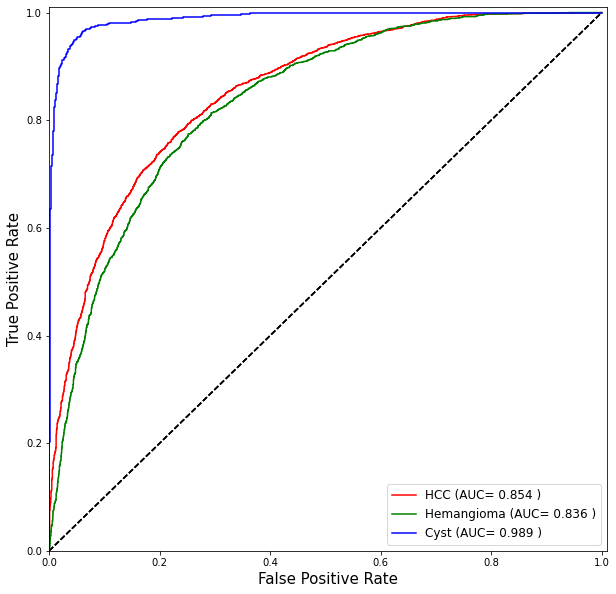

roc_auc_score: 0.893


In [134]:
import pandas as pd
import os
import numpy as np

# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')
savePath = './result/20220320_classification_wc_eff_b2/result/test'
path1 = './result/20220320_classification_wc_eff_b2/result/test/results_all.csv'
df1 = pd.read_csv(path1)
label1 = df1['y_label']
pred1 = df1['y_pred']
pred_0_proba1 = df1['class_0_proba']
pred_1_proba1 = df1['class_1_proba']
pred_2_proba1 = df1['class_2_proba']

print('HCC')
cal_metric1(label1,pred1, 0)
print('-------------------------------')
print('Hemangioma')
cal_metric1(label1,pred1, 1)
print('-------------------------------')
print('Cyst')
cal_metric1(label1,pred1, 2)
print('-------------------------------')
label_name=['HCC','Hemangioma','Cyst']
colors =['r','g','b']

pred_all_proba = np.array(pd.concat([ pred_0_proba1 ,pred_1_proba1 ,pred_2_proba1 ],axis = 1))
label_ohe = np.array(pd.get_dummies(label1))
auc_cal(pred_all_proba, label_ohe ,np.array(label1), 3,label_name,colors,savePath,cv='all')

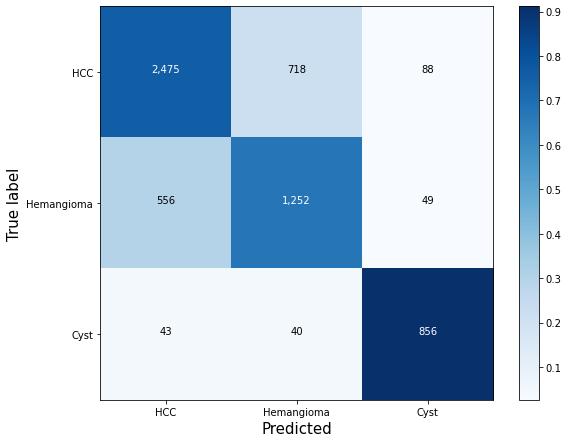

In [135]:
save_dir ='./result/20220320_classification_wc_eff_b2/result/test'
path = './result/20220320_classification_wc_eff_b2/result/test/results_all.csv'
df = pd.read_csv(path)
label = df['y_label']
pred = df['y_pred']

cm = confusion_matrix(label,pred)
plot_confusion_matrix(cm, savepath = os.path.join(save_dir, 'Confusion_matrix_all.tiff'), target_names=['HCC','Hemangioma', 'Cyst'], cmap=None, normalize=False, labels=True, title='Confusion matrix')


# CV1

HCC
Recall: 0.717 (0.681-0.751)
Precision: 0.815 (0.781-0.846)
F1 score: 0.763 (0.738-0.786)
-------------------------------
Hemangioma
Recall: 0.727 (0.679-0.770)
Precision: 0.626 (0.578-0.671)
F1 score: 0.672 (0.639-0.704)
-------------------------------
Cyst
Recall: 0.914 (0.867-0.948)
Precision: 0.842 (0.786-0.887)
F1 score: 0.877 (0.840-0.906)
-------------------------------
 (AUC= 0.848  (0.827-0.870))
 (AUC= 0.848  (0.821-0.874))
 (AUC= 0.989  (0.978-0.999))


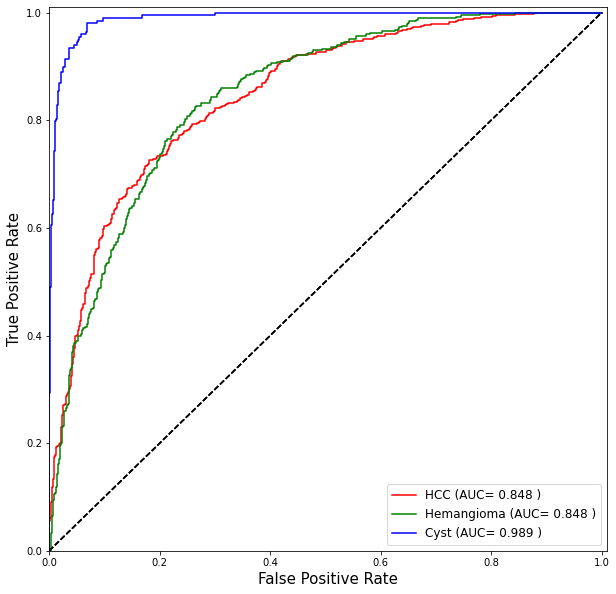

roc_auc_score: 0.895


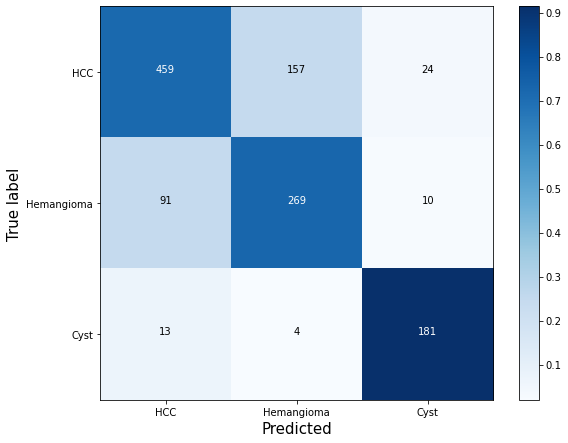

In [136]:
import pandas as pd
import os
import numpy as np

# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')
savePath = './result/20220320_classification_wc_eff_b2/result/test'
path1 = './result/20220320_classification_wc_eff_b2/result/test/results1.csv'
df1 = pd.read_csv(path1)
label1 = df1['y_label']
pred1 = df1['y_pred']
pred_0_proba1 = df1['class_0_proba']
pred_1_proba1 = df1['class_1_proba']
pred_2_proba1 = df1['class_2_proba']

print('HCC')
cal_metric1(label1,pred1, 0)
print('-------------------------------')
print('Hemangioma')
cal_metric1(label1,pred1, 1)
print('-------------------------------')
print('Cyst')
cal_metric1(label1,pred1, 2)
print('-------------------------------')
label_name=['HCC','Hemangioma','Cyst']
colors =['r','g','b']

pred_all_proba = np.array(pd.concat([ pred_0_proba1 ,pred_1_proba1 ,pred_2_proba1 ],axis = 1))
label_ohe = np.array(pd.get_dummies(label1))
auc_cal(pred_all_proba, label_ohe ,np.array(label1), 3,label_name,colors,savePath,cv='_1')

save_dir ='./result/20220320_classification_wc_eff_b2/result/test'
path = './result/20220320_classification_wc_eff_b2/result/test/results1.csv'
df = pd.read_csv(path)
label = df['y_label']
pred = df['y_pred']

cm = confusion_matrix(label,pred)
plot_confusion_matrix(cm, savepath = os.path.join(save_dir, 'Confusion_matrix_1.tiff'), target_names=['HCC','Hemangioma', 'Cyst'], cmap=None, normalize=False, labels=True, title='Confusion matrix')


# CV2

HCC
Recall: 0.838 (0.808-0.865)
Precision: 0.798 (0.766-0.826)
F1 score: 0.818 (0.796-0.837)
-------------------------------
Hemangioma
Recall: 0.595 (0.544-0.644)
Precision: 0.718 (0.664-0.766)
F1 score: 0.651 (0.614-0.687)
-------------------------------
Cyst
Recall: 0.968 (0.932-0.986)
Precision: 0.835 (0.780-0.879)
F1 score: 0.897 (0.862-0.923)
-------------------------------
 (AUC= 0.878  (0.858-0.897))
 (AUC= 0.859  (0.834-0.885))
 (AUC= 0.992  (0.983-1.000))


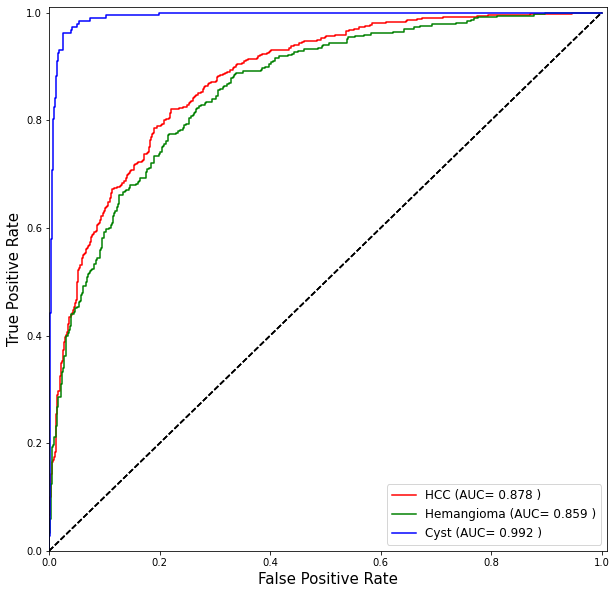

roc_auc_score: 0.910


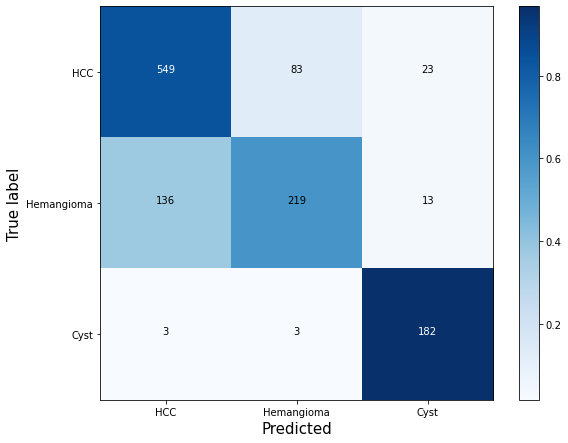

In [137]:
import pandas as pd
import os
import numpy as np

# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')
savePath = './result/20220320_classification_wc_eff_b2/result/test'
path1 = './result/20220320_classification_wc_eff_b2/result/test/results2.csv'
df1 = pd.read_csv(path1)
label1 = df1['y_label']
pred1 = df1['y_pred']
pred_0_proba1 = df1['class_0_proba']
pred_1_proba1 = df1['class_1_proba']
pred_2_proba1 = df1['class_2_proba']

print('HCC')
cal_metric1(label1,pred1, 0)
print('-------------------------------')
print('Hemangioma')
cal_metric1(label1,pred1, 1)
print('-------------------------------')
print('Cyst')
cal_metric1(label1,pred1, 2)
print('-------------------------------')
label_name=['HCC','Hemangioma','Cyst']
colors =['r','g','b']

pred_all_proba = np.array(pd.concat([ pred_0_proba1 ,pred_1_proba1 ,pred_2_proba1 ],axis = 1))
label_ohe = np.array(pd.get_dummies(label1))
auc_cal(pred_all_proba, label_ohe ,np.array(label1), 3,label_name,colors,savePath,cv='_2')

save_dir ='./result/20220320_classification_wc_eff_b2/result/test'
path = './result/20220320_classification_wc_eff_b2/result/test/results2.csv'
df = pd.read_csv(path)
label = df['y_label']
pred = df['y_pred']

cm = confusion_matrix(label,pred)
plot_confusion_matrix(cm, savepath = os.path.join(save_dir, 'Confusion_matrix_2.tiff'), target_names=['HCC','Hemangioma', 'Cyst'], cmap=None, normalize=False, labels=True, title='Confusion matrix')


HCC
Recall: 0.733 (0.698-0.766)
Precision: 0.767 (0.732-0.799)
F1 score: 0.750 (0.725-0.772)
-------------------------------
Hemangioma
Recall: 0.611 (0.561-0.659)
Precision: 0.598 (0.548-0.645)
F1 score: 0.604 (0.570-0.638)
-------------------------------
Cyst
Recall: 0.917 (0.868-0.949)
Precision: 0.830 (0.774-0.876)
F1 score: 0.871 (0.834-0.901)
-------------------------------
 (AUC= 0.836  (0.814-0.858))
 (AUC= 0.812  (0.784-0.840))
 (AUC= 0.988  (0.977-0.999))


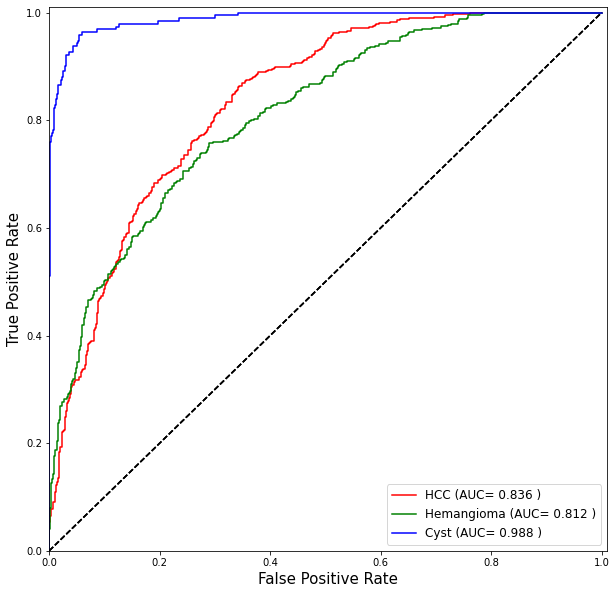

roc_auc_score: 0.878


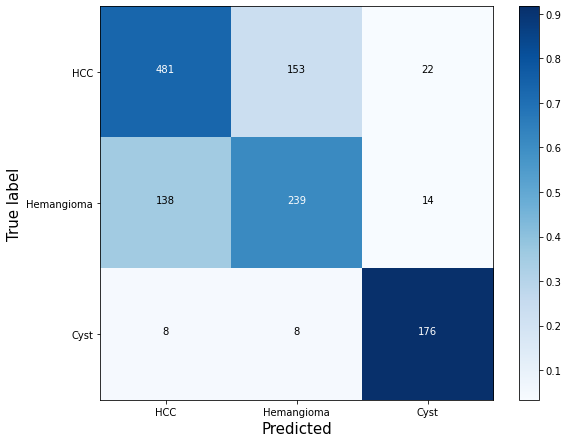

In [138]:
import pandas as pd
import os
import numpy as np

# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')
savePath = './result/20220320_classification_wc_eff_b2/result/test'
path1 = './result/20220320_classification_wc_eff_b2/result/test/results3.csv'
df1 = pd.read_csv(path1)
label1 = df1['y_label']
pred1 = df1['y_pred']
pred_0_proba1 = df1['class_0_proba']
pred_1_proba1 = df1['class_1_proba']
pred_2_proba1 = df1['class_2_proba']

print('HCC')
cal_metric1(label1,pred1, 0)
print('-------------------------------')
print('Hemangioma')
cal_metric1(label1,pred1, 1)
print('-------------------------------')
print('Cyst')
cal_metric1(label1,pred1, 2)
print('-------------------------------')
label_name=['HCC','Hemangioma','Cyst']
colors =['r','g','b']

pred_all_proba = np.array(pd.concat([ pred_0_proba1 ,pred_1_proba1 ,pred_2_proba1 ],axis = 1))
label_ohe = np.array(pd.get_dummies(label1))
auc_cal(pred_all_proba, label_ohe ,np.array(label1), 3,label_name,colors,savePath,cv='_3')

save_dir ='./result/20220320_classification_wc_eff_b2/result/test'
path = './result/20220320_classification_wc_eff_b2/result/test/results3.csv'
df = pd.read_csv(path)
label = df['y_label']
pred = df['y_pred']

cm = confusion_matrix(label,pred)
plot_confusion_matrix(cm, savepath = os.path.join(save_dir, 'Confusion_matrix_3.tiff'), target_names=['HCC','Hemangioma', 'Cyst'], cmap=None, normalize=False, labels=True, title='Confusion matrix')


# CV4

HCC
Recall: 0.744 (0.709-0.777)
Precision: 0.835 (0.802-0.864)
F1 score: 0.787 (0.763-0.809)
-------------------------------
Hemangioma
Recall: 0.737 (0.688-0.781)
Precision: 0.608 (0.561-0.654)
F1 score: 0.667 (0.633-0.699)
-------------------------------
Cyst
Recall: 0.901 (0.849-0.937)
Precision: 0.926 (0.876-0.959)
F1 score: 0.913 (0.879-0.939)
-------------------------------
 (AUC= 0.865  (0.844-0.885))
 (AUC= 0.844  (0.817-0.871))
 (AUC= 0.993  (0.984-1.000))


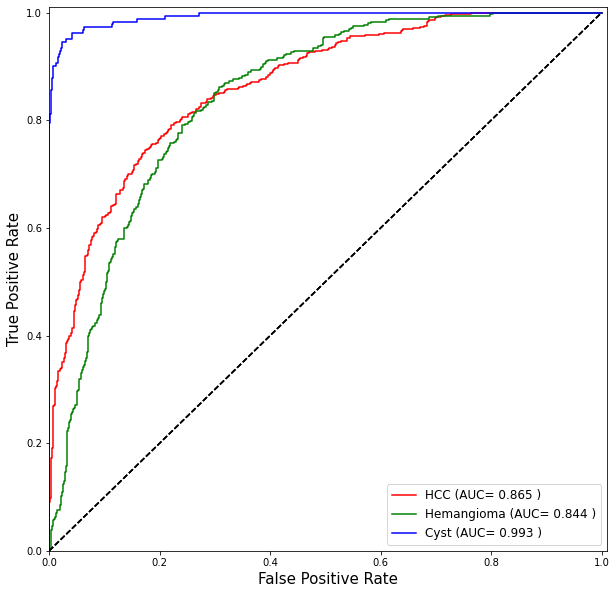

roc_auc_score: 0.900


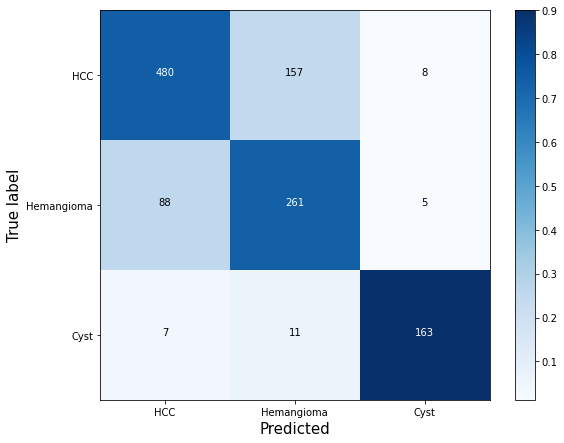

In [139]:
import pandas as pd
import os
import numpy as np

# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')
savePath = './result/20220320_classification_wc_eff_b2/result/test'
path1 = './result/20220320_classification_wc_eff_b2/result/test/results4.csv'
df1 = pd.read_csv(path1)
label1 = df1['y_label']
pred1 = df1['y_pred']
pred_0_proba1 = df1['class_0_proba']
pred_1_proba1 = df1['class_1_proba']
pred_2_proba1 = df1['class_2_proba']

print('HCC')
cal_metric1(label1,pred1, 0)
print('-------------------------------')
print('Hemangioma')
cal_metric1(label1,pred1, 1)
print('-------------------------------')
print('Cyst')
cal_metric1(label1,pred1, 2)
print('-------------------------------')
label_name=['HCC','Hemangioma','Cyst']
colors =['r','g','b']

pred_all_proba = np.array(pd.concat([ pred_0_proba1 ,pred_1_proba1 ,pred_2_proba1 ],axis = 1))
label_ohe = np.array(pd.get_dummies(label1))
auc_cal(pred_all_proba, label_ohe ,np.array(label1), 3,label_name,colors,savePath,cv='_4')

save_dir ='./result/20220320_classification_wc_eff_b2/result/test'
path = './result/20220320_classification_wc_eff_b2/result/test/results4.csv'
df = pd.read_csv(path)
label = df['y_label']
pred = df['y_pred']

cm = confusion_matrix(label,pred)
plot_confusion_matrix(cm, savepath = os.path.join(save_dir, 'Confusion_matrix_4.tiff'), target_names=['HCC','Hemangioma', 'Cyst'], cmap=None, normalize=False, labels=True, title='Confusion matrix')


# CV5

HCC
Recall: 0.739 (0.704-0.771)
Precision: 0.815 (0.782-0.844)
F1 score: 0.775 (0.751-0.797)
-------------------------------
Hemangioma
Recall: 0.706 (0.658-0.750)
Precision: 0.592 (0.545-0.637)
F1 score: 0.644 (0.610-0.676)
-------------------------------
Cyst
Recall: 0.856 (0.795-0.901)
Precision: 0.895 (0.841-0.934)
F1 score: 0.875 (0.836-0.907)
-------------------------------
 (AUC= 0.848  (0.827-0.869))
 (AUC= 0.828  (0.801-0.856))
 (AUC= 0.987  (0.975-0.999))


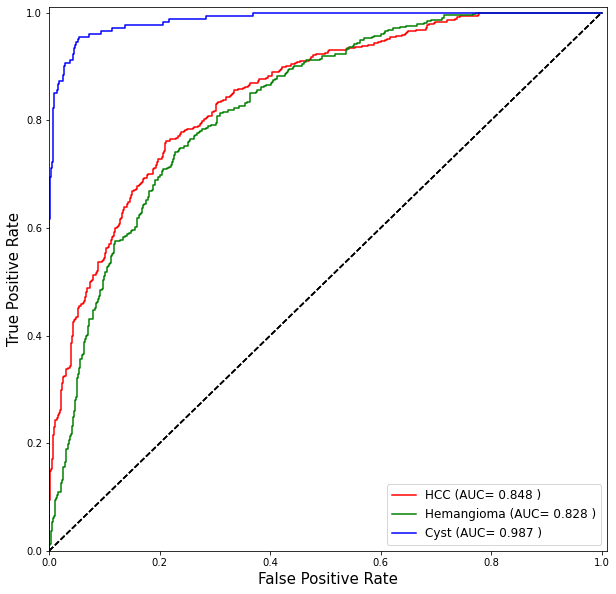

roc_auc_score: 0.888


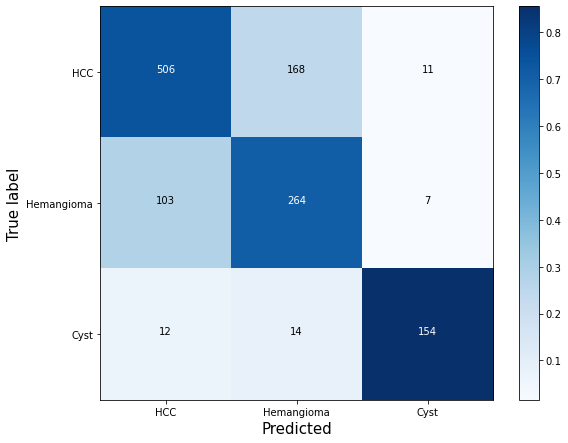

In [140]:
import pandas as pd
import os
import numpy as np

# os.chdir('/home/ubuntu/gcubme_ai/Workspace/S_Oh/US_Liver')
savePath = './result/20220320_classification_wc_eff_b2/result/test'
path1 = './result/20220320_classification_wc_eff_b2/result/test/results5.csv'
df1 = pd.read_csv(path1)
label1 = df1['y_label']
pred1 = df1['y_pred']
pred_0_proba1 = df1['class_0_proba']
pred_1_proba1 = df1['class_1_proba']
pred_2_proba1 = df1['class_2_proba']

print('HCC')
cal_metric1(label1,pred1, 0)
print('-------------------------------')
print('Hemangioma')
cal_metric1(label1,pred1, 1)
print('-------------------------------')
print('Cyst')
cal_metric1(label1,pred1, 2)
print('-------------------------------')
label_name=['HCC','Hemangioma','Cyst']
colors =['r','g','b']

pred_all_proba = np.array(pd.concat([ pred_0_proba1 ,pred_1_proba1 ,pred_2_proba1 ],axis = 1))
label_ohe = np.array(pd.get_dummies(label1))
auc_cal(pred_all_proba, label_ohe ,np.array(label1), 3,label_name,colors,savePath,cv='_5')

save_dir ='./result/20220320_classification_wc_eff_b2/result/test'
path = './result/20220320_classification_wc_eff_b2/result/test/results5.csv'
df = pd.read_csv(path)
label = df['y_label']
pred = df['y_pred']

cm = confusion_matrix(label,pred)
plot_confusion_matrix(cm, savepath = os.path.join(save_dir, 'Confusion_matrix_5.tiff'), target_names=['HCC','Hemangioma', 'Cyst'], cmap=None, normalize=False, labels=True, title='Confusion matrix')
